# 0.0. IMPORTS

In [16]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
import pickle
import json
import random

from boruta                 import BorutaPy
from sklearn.ensemble       import RandomForestRegressor
from IPython.display        import Image
from scipy                  import stats as ss
from sklearn.preprocessing  import RobustScaler, MinMaxScaler,LabelEncoder
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.linear_model   import LinearRegression, Lasso

## 0.1. Helper Function

In [17]:
def cramer_v(x,y):
    cm=pd.crosstab(x,y).values
    n=cm.sum()
    r,k=cm.shape
    chi2=ss.chi2_contingency(cm)[0]
    chi2coor=max(0,chi2-((k-1)*(r-1)/(n-1)))
    kcorr=k-((k-1)**2)/(n-1)
    rcorr=r-((r-1)**2)/(n-1)
    return(np.sqrt((chi2coor/n)/(min(kcorr-1,rcorr-1))))
    
def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)
    
def mean_absolute_percentage_error_2(y,yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae=mean_absolute_error(y,yhat)
    mape=mean_absolute_percentage_error_2(y,yhat)
    rmse=np.sqrt(mean_squared_error(y,yhat))
    return pd.DataFrame({'Model Name': model_name,
                        'MAE':mae,
                        'MAPE':mape,
                        'RMSE':rmse}, index=[0])
def cross_validation(x_training,kfold,model_name,model,verbose=False):
    mae_list=[]
    mape_list=[]
    rmse_list=[]
    for k in reversed(range(1,kfold+1)):
        # start and end for validation
        validation_start_date=x_training['date'].max()-datetime.timedelta(days=k*6*7)
        validation_end_date=x_training['date'].max()-datetime.timedelta(days=(k-1)*6*7)
        validation_end_date
        # filtering dataset
        training=x_training[x_training['date']<validation_start_date]
        validation=x_training[(x_training['date']>=validation_start_date)&(x_training['date']<=validation_end_date)]
        # training dataset
        xtraining=training.drop(['date','sales'],axis=1)
        ytraining=training['sales']
        # validation dataset
        xvalidation=validation.drop(['date','sales'],axis=1)
        yvalidation=validation['sales']
        # model
        m=model.fit(xtraining,ytraining)
        # prediction
        yhat=m.predict(xvalidation)
        # performance
        m_result=ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))
        #store performance of each kfold interation
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        if verbose:
            print('\nKFold Number {}'.format(k))
    return pd.DataFrame({'Model Name': model_name,
                        'MAE CV': np.round(np.mean(mae_list),2).astype(str)+' +/- '+np.round(np.std(mae_list),2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list),2).astype(str)+' +/- '+np.round(np.std(mape_list),2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list),2).astype(str)+' +/- '+np.round(np.std(rmse_list),2).astype(str)},index=[0])

## 0.2. Loading Data

In [18]:
df_sales_raw=pd.read_csv('./data/train.csv', low_memory=False)
df_store_raw=pd.read_csv('./data/store.csv', low_memory=False)

#merge
df_raw=pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')

# 1.0. PASSO 1 - DESCRIÇÃO DOS DADOS

In [19]:
df1=df_raw.copy()

## 1.1. Rename Columns

In [20]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase=lambda x: inflection.underscore(x)

cols_new=list(map(snakecase, cols_old))
df1.columns=cols_new

## 1.2. Data Dimensions

In [21]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [22]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [23]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [24]:
#competition_distance
df1['competition_distance']=df1['competition_distance'].apply(lambda x:200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

#competition_open_since_year
df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

#promo2_since_week
df1['promo2_since_week']=df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

#promo2_since_year
df1['promo2_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

#promo_interval
month_map={1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec',}
df1['promo_interval'].fillna(0,inplace=True)
df1['month_map']=df1['date'].dt.month.map(month_map)
df1['is_promo']=df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)

## 1.6. Change Types

In [25]:
df1['competition_open_since_month']=df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year']=df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week']=df1['promo2_since_week'].astype('int64')
df1['promo2_since_year']=df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [26]:
num_attributes=df1.select_dtypes(include=['int64','float64'])
cat_attributes=df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [27]:
# Central Tendency - mean, median
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(min)).T
d3=pd.DataFrame(num_attributes.apply(max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5=pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6=pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


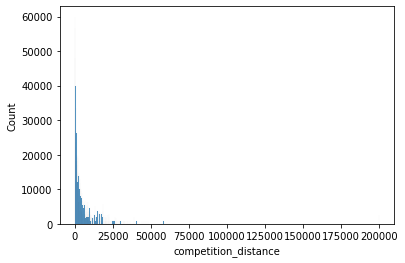

In [28]:
sns.histplot(df1['competition_distance']);

### 1.7.2. Categorical Attributes

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

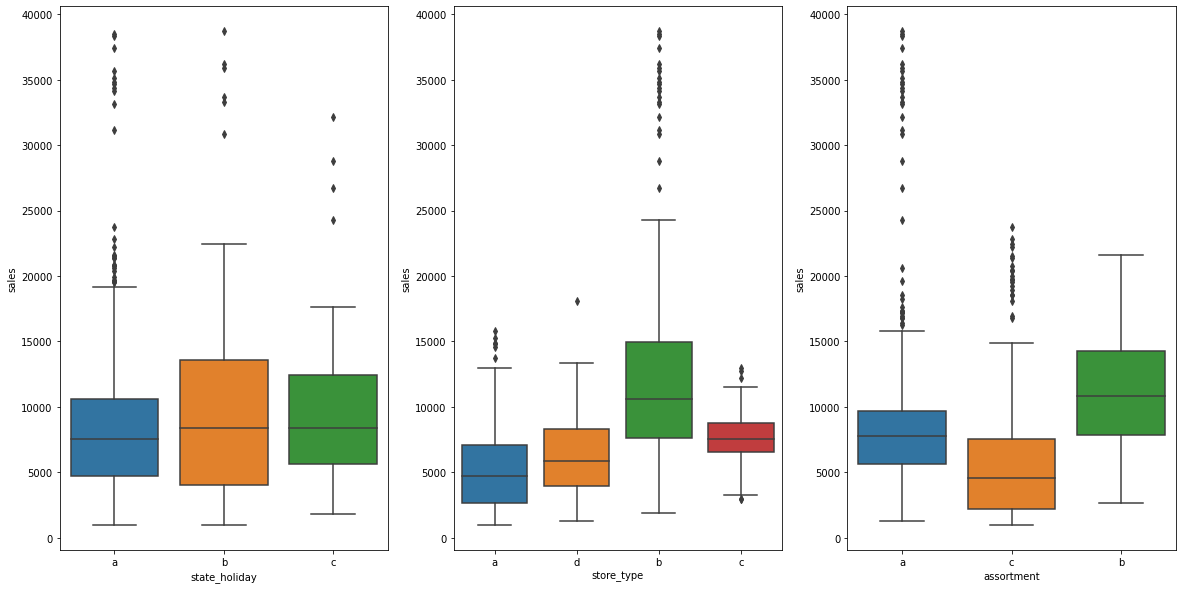

In [30]:
aux1=df1[(df1['state_holiday']!='0')&(df1['sales']>0)]
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)
plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)
plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0. PASSO 2 - FEATURE ENGEREERING

In [31]:
df2=df1.copy()

## 2.1. Mapa Mental de Hipóteses

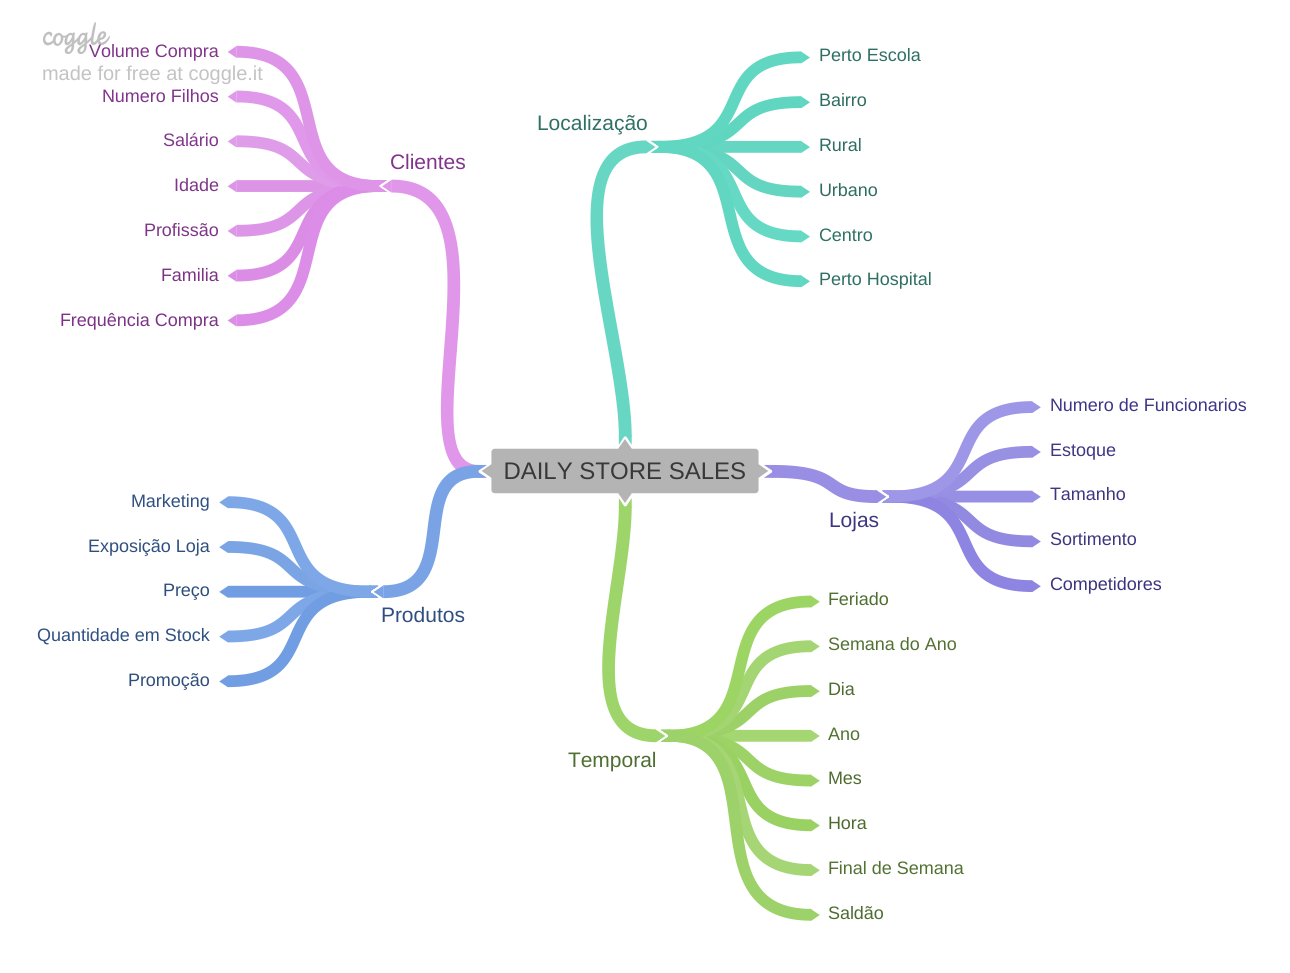

In [23]:
Image('./image/DAILY_STORE_SALES.png')

## 2.2. Criação de Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com mais exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com  mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com  mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engeneering 

In [32]:
# year
df2['year']=df2['date'].dt.year
# month
df2['month']=df2['date'].dt.month
# day
df2['day']=df2['date'].dt.day
# week of year
df2['week_of_year']=df2['date'].dt.weekofyear
# year week
df2['year_week']=df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since']=df2.apply(lambda x:datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month']=((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')
# promo since
df2['promo_since']=df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since']=df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w')-datetime.timedelta(days=7))
df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment']=df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')
# state holiday
df2['state_holiday']=df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christimas' if x=='c' else 'regular_day')

C:\Users\rafae\AppData\Local\Temp\ipykernel_47380\106408327.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year']=df2['date'].dt.weekofyear


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [33]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [34]:
df3=df3[(df3['open']!=0)&(df3['sales']>0)]

## 3.2. Seleção das Colunas

In [35]:
cols_drop=['customers','open','promo_interval','month_map']
df3=df3.drop(cols_drop, axis=1)

# 4.0. PASSO 4 - EDA - Exploratory Data Analisys

In [45]:
df4=df3.copy()

## 4.1. Analise Univariada

In [46]:
num_attributes=df4.select_dtypes(include=['int64','float64'])
cat_attributes=df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 4.1.1. Responde Variable

c:\Users\rafae\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

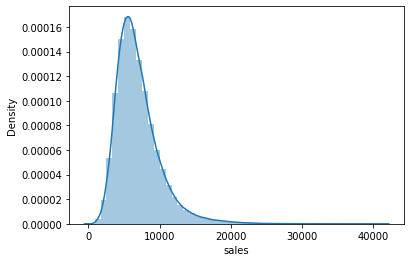

In [47]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

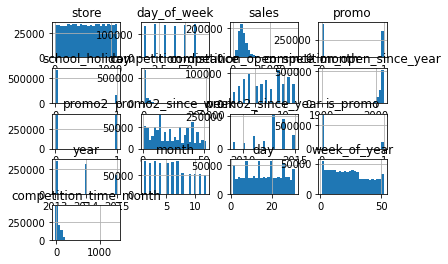

In [48]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

c:\Users\rafae\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\rafae\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\rafae\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

<AxesSubplot:xlabel='sales', ylabel='Density'>

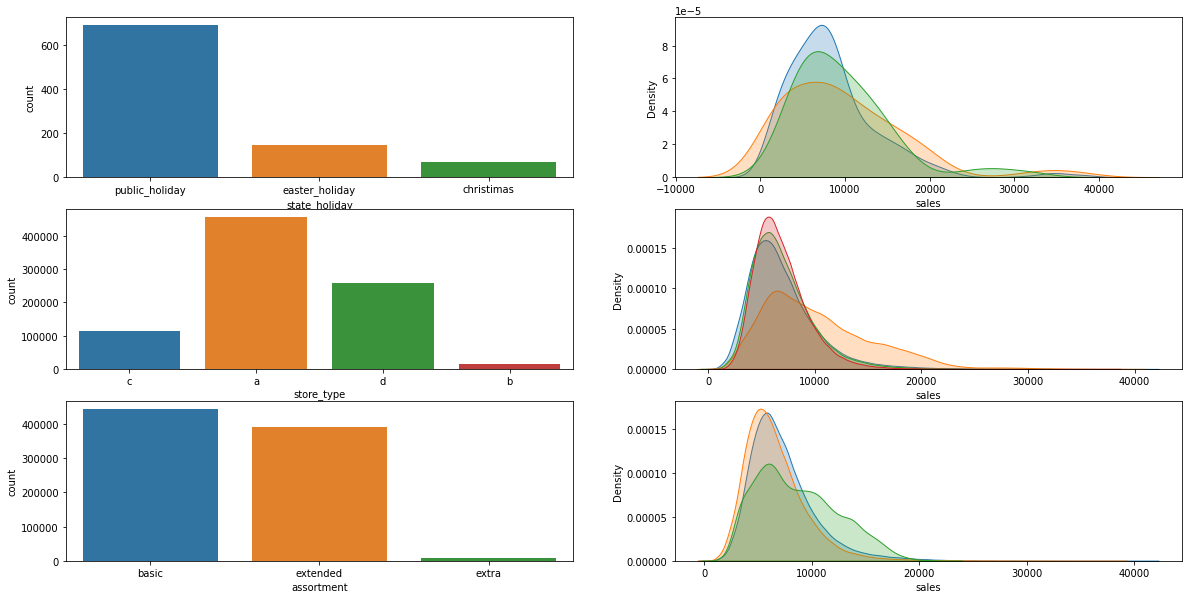

In [49]:
plt.figure(figsize=(20,10))
# state holiday
plt.subplot(3,2,1)
sns.countplot(df4[df4['state_holiday']!='regular_day']['state_holiday'])
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday']=='christimas']['sales'], label='christimas',shade=True)
# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label='a',shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label='b',shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label='c',shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label='d',shade=True)
# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label='extended',shade=True)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], label='basic',shade=True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], label='extra',shade=True)

## 4.2. Analise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.

**FALSA** Lojas com maior sortimento vendem menos

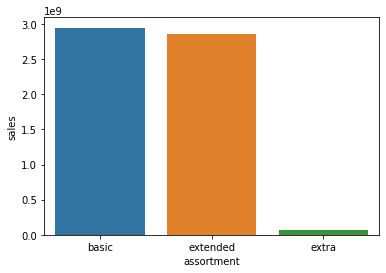

In [50]:
aux1=df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

<AxesSubplot:xlabel='year_week'>

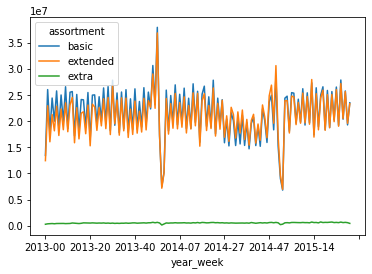

In [51]:
aux2=df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot()

<AxesSubplot:xlabel='year_week'>

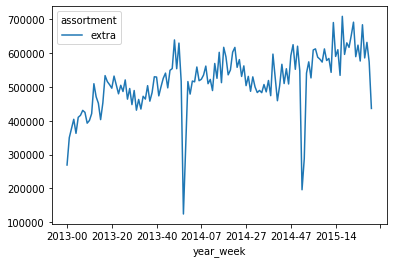

In [52]:
aux3=aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com competidores mais proximos vendem mais

<AxesSubplot:>

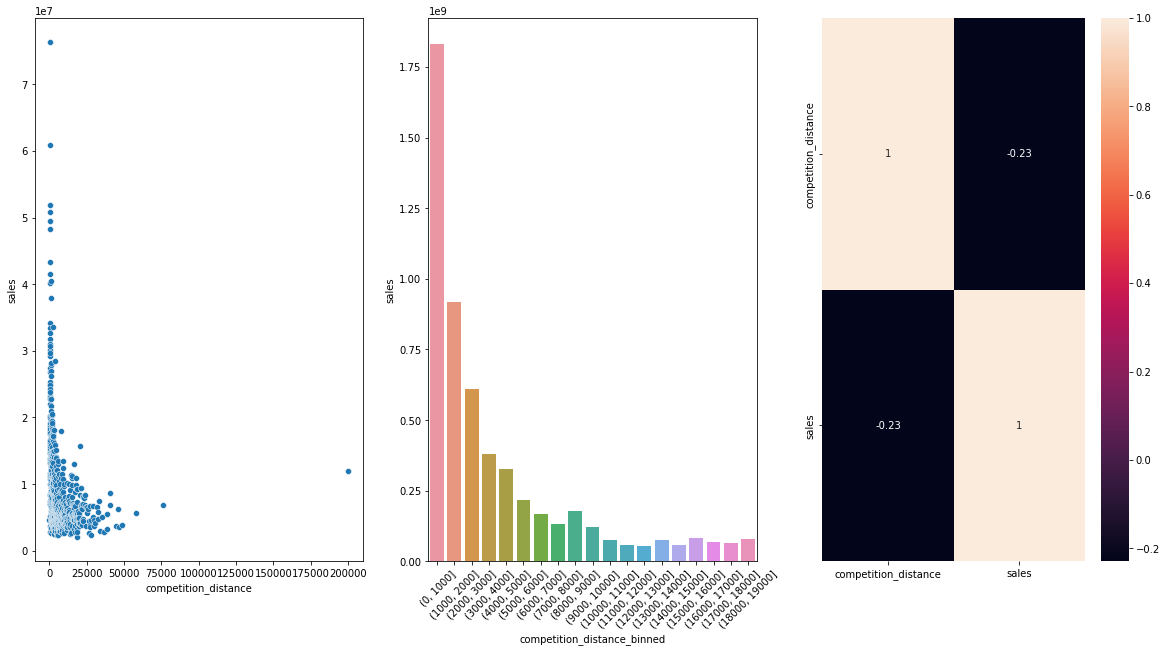

In [53]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
aux1=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance',y='sales',data=aux1)
plt.subplot(1,3,2)
aux1=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
bins=list(np.arange(0,20000,1000))
aux1['competition_distance_binned']=pd.cut(aux1['competition_distance'],bins=bins)
aux2=aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux2)
plt.xticks(rotation=45)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H3. Lojas com competidores à mais tempo deveriam vender mais.

**FALSO** Lojas com competidores à mais tempo vendem menos


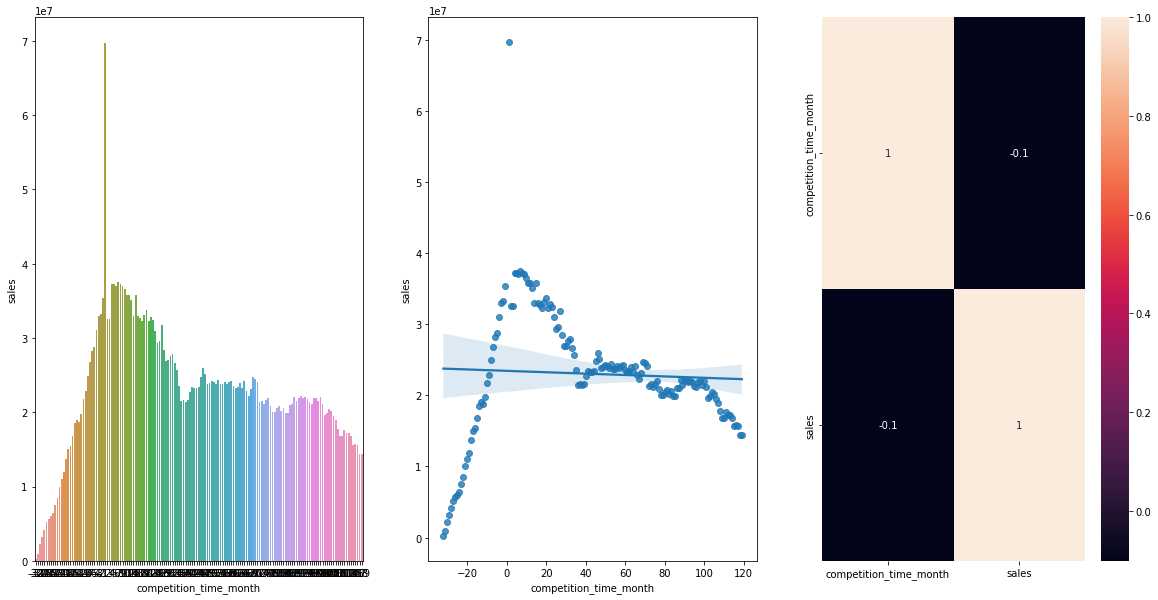

In [54]:
aux1=df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2=aux1[(aux1['competition_time_month']<120)&(aux1['competition_time_month']!=0)]
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2)
plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2);
plt.subplot(1,3,3)
x=sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSO** Lojas com promoções ativas por mais tempo vendem menos depois de um certo periodo de promoção

<AxesSubplot:>

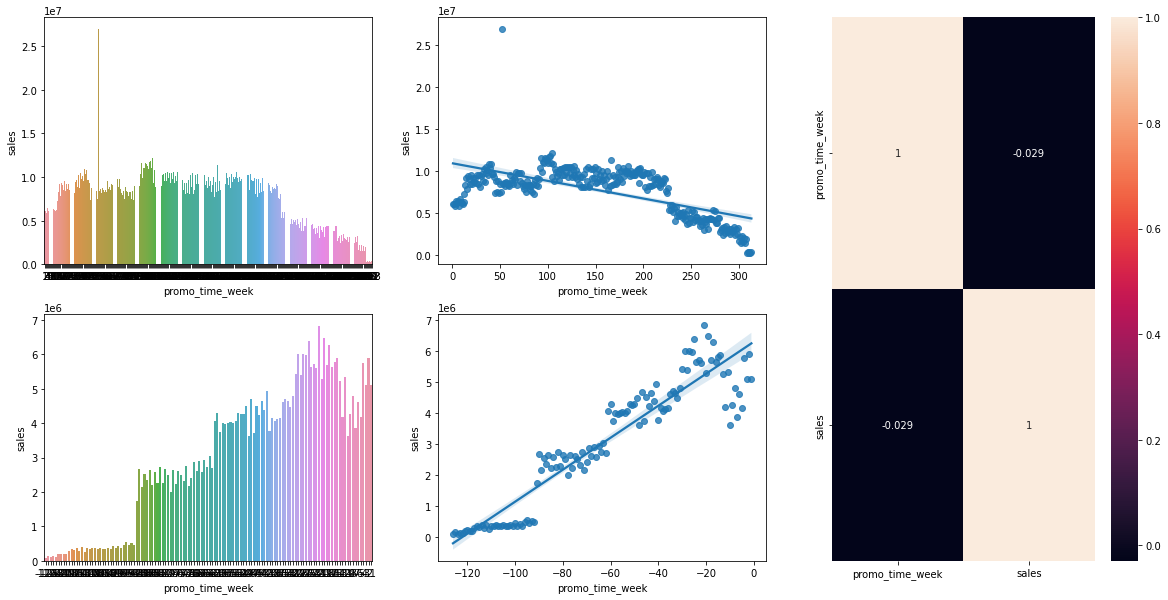

In [55]:
aux1=df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
aux2=aux1[aux1['promo_time_week']>0]
aux3=aux1[aux1['promo_time_week']<0]
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
sns.barplot(x='promo_time_week',y='sales',data=aux2);
plt.subplot(2,3,2)
sns.regplot(x='promo_time_week',y='sales',data=aux2);
plt.subplot(2,3,4)
sns.barplot(x='promo_time_week',y='sales',data=aux3);
plt.subplot(2,3,5)
sns.regplot(x='promo_time_week',y='sales',data=aux3);
plt.subplot(2,3,(3,6))
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais
**FALSO** Lojas com mais promoções consecutivas vendem menos

In [56]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


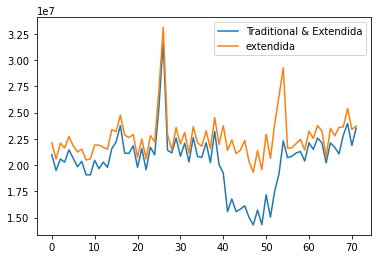

In [57]:
aux1=df4[(df4['promo']==1)&(df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2=df4[(df4['promo']==1)&(df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax=aux1.plot()
aux2.plot(ax=ax)
ax.legend(labels=['Traditional & Extendida','extendida'])

### H7. Lojas abertas durante o feriado de natal deveriam vender mais.

**FALSO** Lojas abertas durante o feriado de natal vendem menos

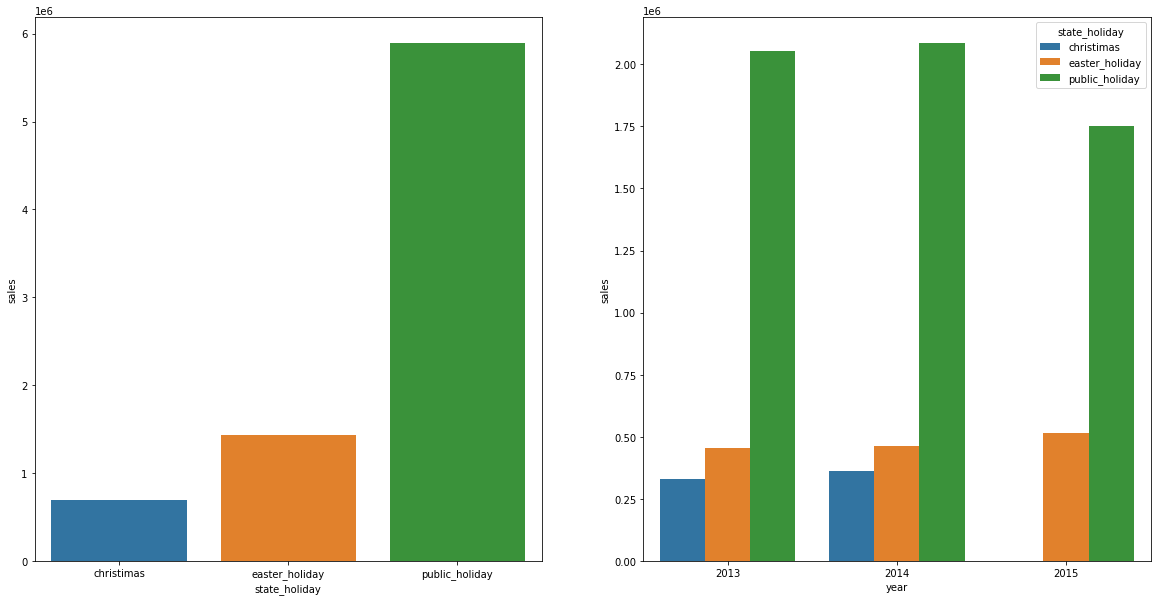

In [58]:
aux=df4[df4['state_holiday']!='regular_day']
aux1=aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
aux2=aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.barplot(x='state_holiday',y='sales',data=aux1);
plt.subplot(1,2,2)
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.

**FALSO** Lojas vedem menos ao longo dos anos

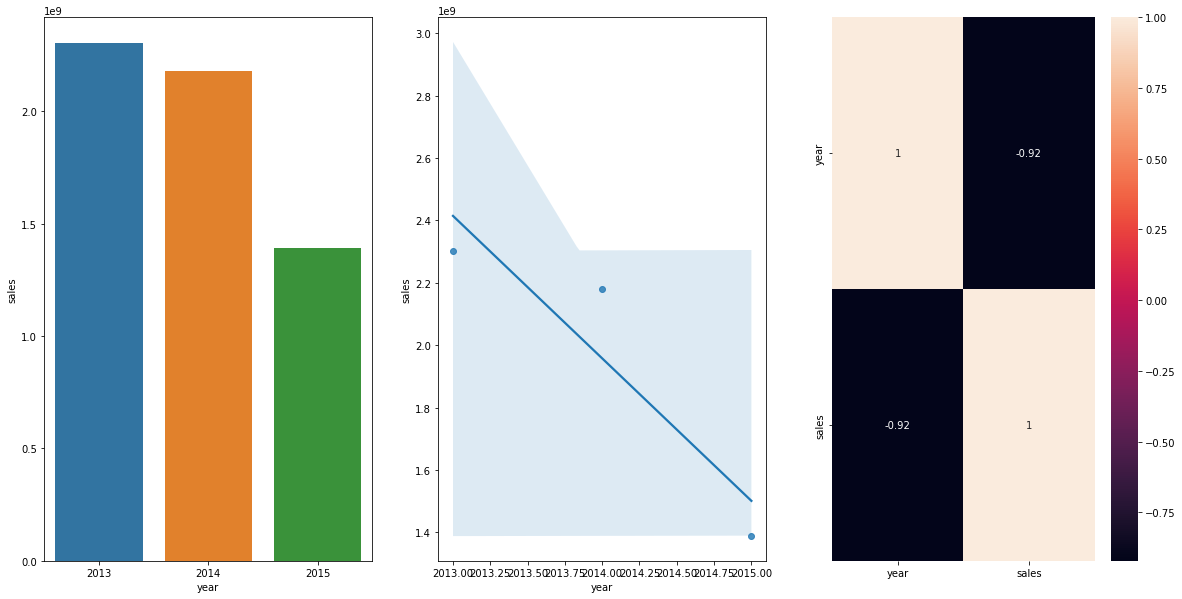

In [59]:
aux1=df4[['year','sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.

**FALSO**

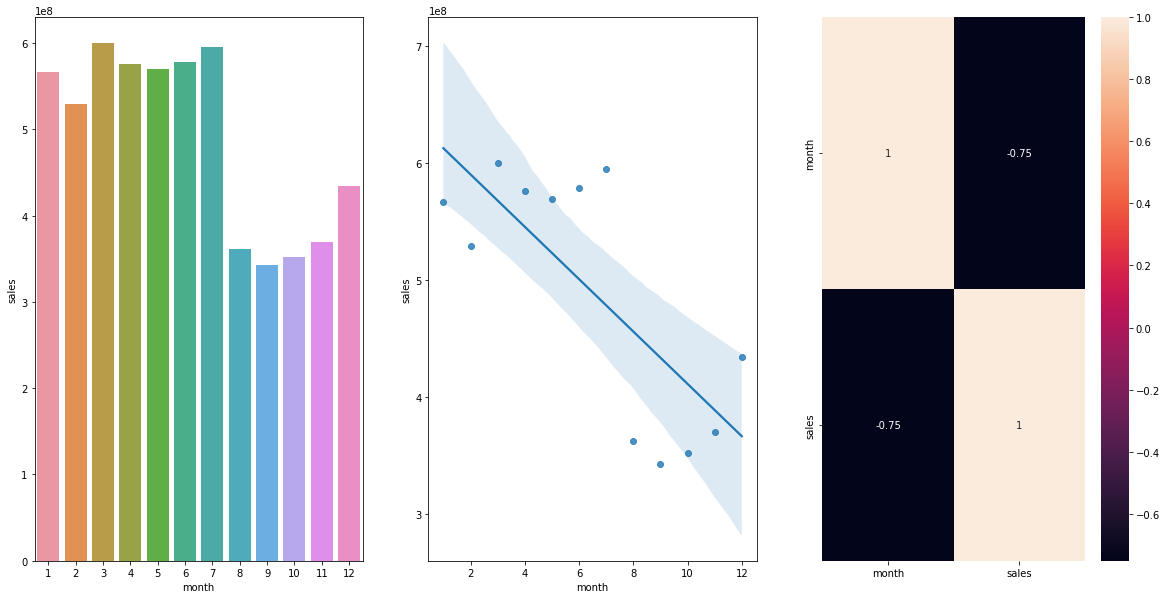

In [60]:
aux1=df4[['month','sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês 

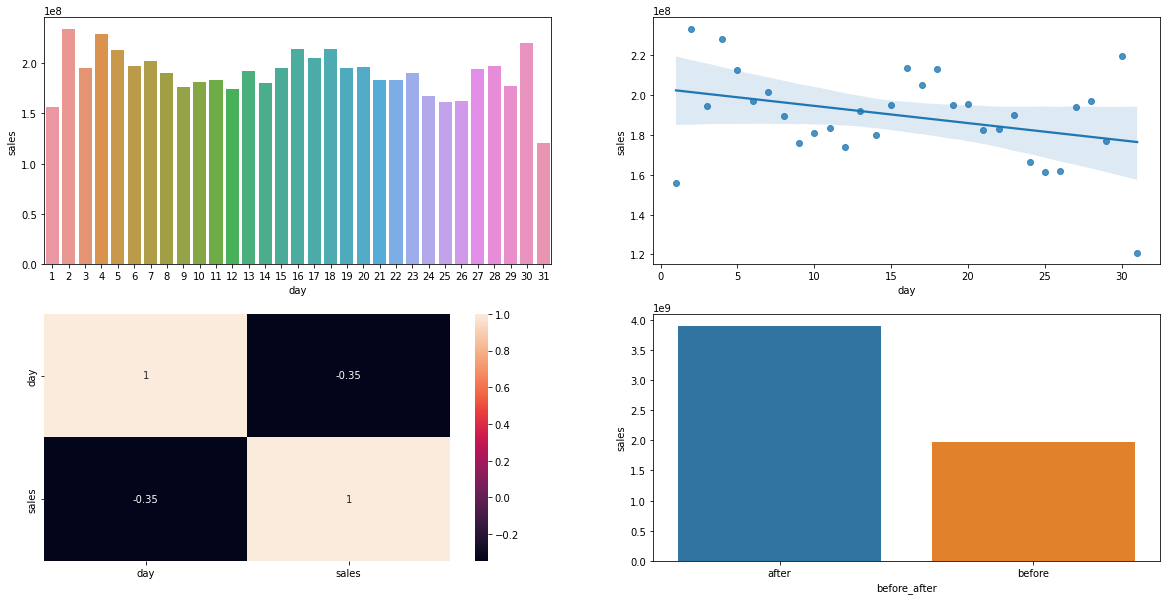

In [61]:
aux1=df4[['day','sales']].groupby('day').sum().reset_index()
aux1['before_after']=aux1['day'].apply(lambda x: 'before' if x<=10 else 'after')
aux2=aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRO** Lojas vendem menos no final de semana

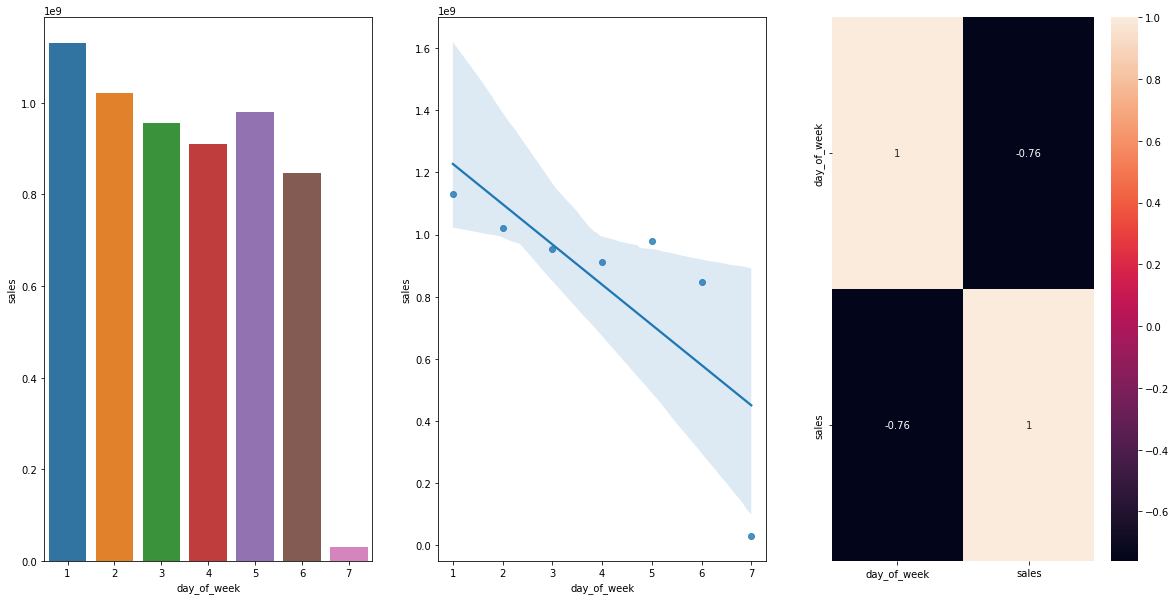

In [62]:
aux1=df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRO** Lojas vendem menos durante os feriados escolares, exceto nos meses de Julho e Agosto

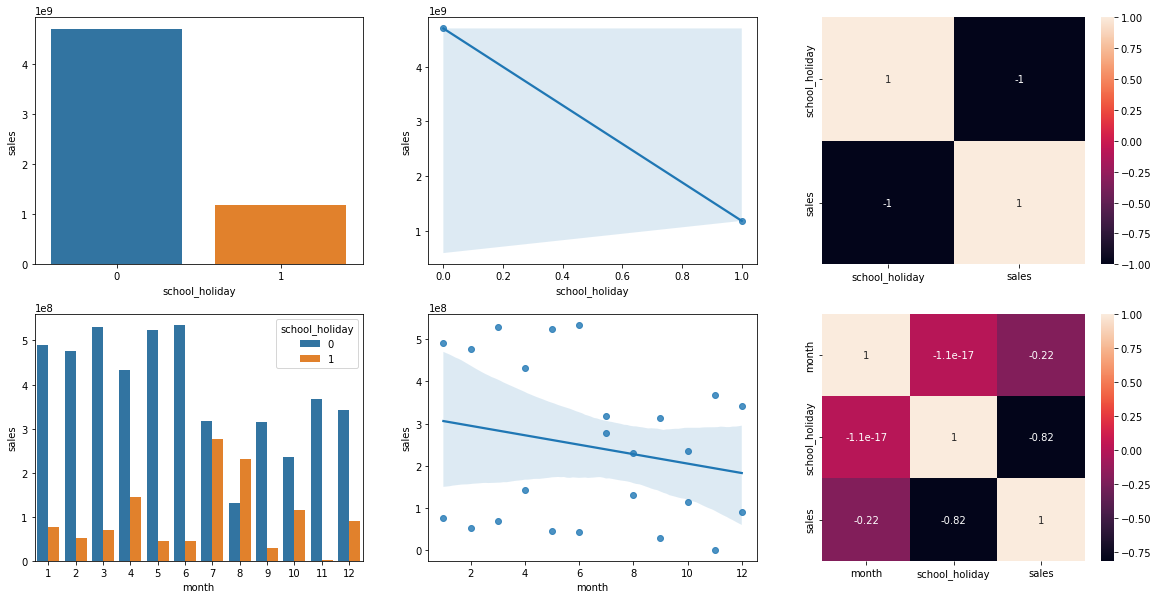

In [63]:
aux1=df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
aux2=df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
sns.barplot(x='school_holiday',y='sales',data=aux1);

plt.subplot(2,3,2)
sns.regplot(x='school_holiday',y='sales',data=aux1);

plt.subplot(2,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

plt.subplot(2,3,4)
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

plt.subplot(2,3,5)
sns.regplot(x='month',y='sales',data=aux2);

plt.subplot(2,3,6)
sns.heatmap(aux2.corr(method='pearson'),annot=True);

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

<AxesSubplot:>

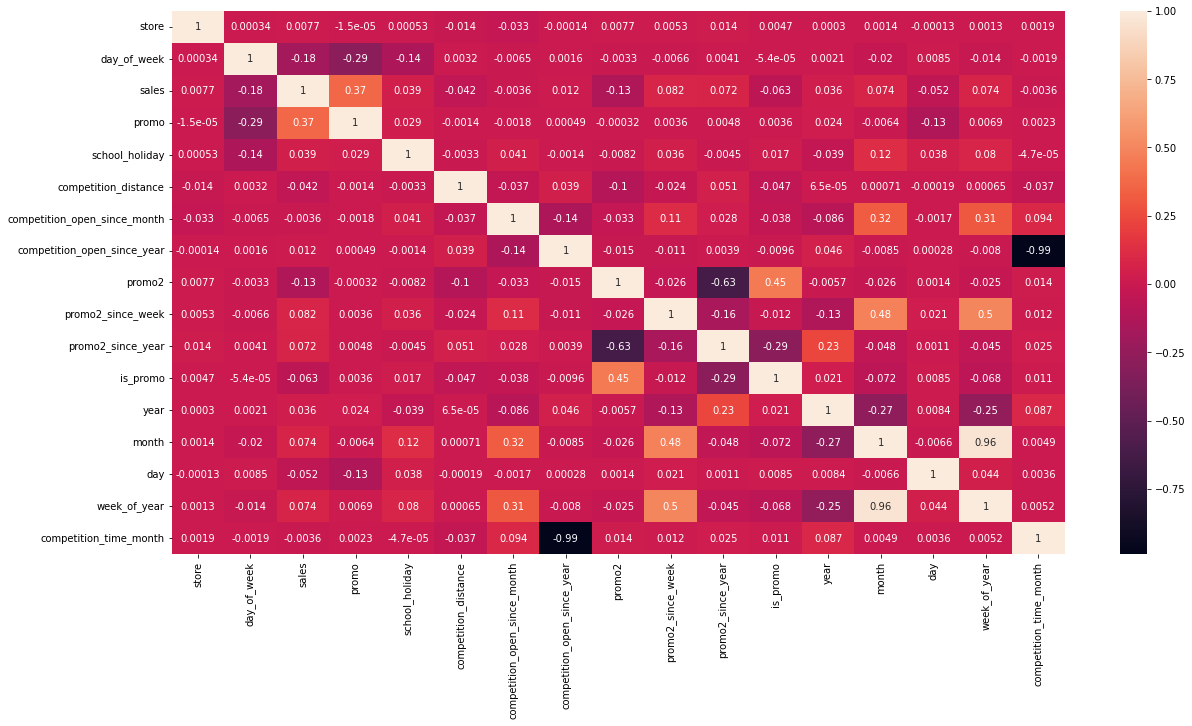

In [65]:
correlation=num_attributes.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot=True)

### 4.3.2. Categorical Attributes

<AxesSubplot:>

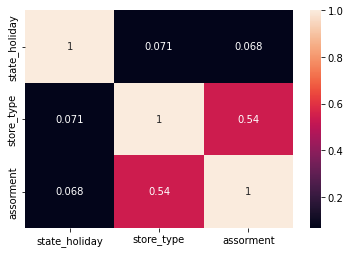

In [66]:
a=df4.select_dtypes(include='object')

a1=cramer_v(a['state_holiday'],a['state_holiday'])
a2=cramer_v(a['state_holiday'],a['store_type'])
a3=cramer_v(a['state_holiday'],a['assortment'])

a4=cramer_v(a['store_type'],a['state_holiday'])
a5=cramer_v(a['store_type'],a['store_type'])
a6=cramer_v(a['store_type'],a['assortment'])

a7=cramer_v(a['assortment'],a['state_holiday'])
a8=cramer_v(a['assortment'],a['store_type'])
a9=cramer_v(a['assortment'],a['assortment'])

d=pd.DataFrame({'state_holiday':[a1,a2,a3],
                'store_type':[a4,a5,a6],
                'assorment':[a7,a8,a9]})
d=d.set_index(d.columns)

sns.heatmap(d,annot=True)

# 5.0. PASSO 5 - DATA PREPARATION

In [67]:
df5=df4.copy()

## 5.1. Rescaling

In [68]:
mms=MinMaxScaler()
# promo time week
df5['promo_time_week']=mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms,open('./parameter/promo_time_week_scaler.pkl','wb'))
# year
df5['year']=mms.fit_transform(df5[['year']].values)
pickle.dump(mms,open('./parameter/year_scaler.pkl','wb'))

rs=RobustScaler()
# competition distance
df5['competition_distance']=rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs,open('./parameter/competition_distance_scaler.pkl','wb'))
# competition time month
df5['competition_time_month']=rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs,open('./parameter/competition_time_month_scaler.pkl','wb'))

## 5.3. Transformação

### 5.3.1. Encoding

In [69]:
# state_holiday - One Hot Encoding
df5=pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

# store type - Label Encoding
le=LabelEncoder()
df5['store_type']=le.fit_transform(df5['store_type'])
pickle.dump(le,open('./parameter/store_type_scaler.pkl','wb'))

# assortment - Ordinal Encoding
assortment_dict={'basic':1,'extra':2,'extended':3}
df5['assortment']=df5['assortment'].map(assortment_dict)

### 5.3.2. Nature Transformation (ciclico)

In [70]:
df5['sales']=np.log1p(df5['sales'])

In [71]:
# day of week
df5['day_of_week_sin']=df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos']=df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))
# month
df5['month_sin']=df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos']=df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))
# day
df5['day_sin']=df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos']=df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))
# week_of_year
df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos']=df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# 6.0. PASSO 6 - FEATURE SELECTION


In [72]:
df6=df5.copy()

## 6.1. Split dataframe into training and teste dataset

In [73]:
cols_drop=['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6.drop(columns=cols_drop,inplace=True)

In [74]:
# training dataset
X_train=df6[df6['date']<'2015-06-19']
y_train=X_train['sales']

# teste dataset
X_test=df6[df6['date']>='2015-06-19']
y_test=X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [ ]:
## training and test dataset for Boruta
#X_train_n=X_train.drop(columns=['date','sales']).values
#Y_train_n=Y_train.values.ravel()
#
## define RandonForestRegressor
#rf=RandomForestRegressor(n_jobs=-1)
#
## define boruta
#boruta=BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_n,Y_train_n)

### 6.2.1. Best features from Boruta

In [ ]:
#cols_selected=boruta.support_.tolist()
#
## best features
#x_train_fs=x_train.drop(columns=['date','sales'])
#colsd_selected_boruta=x_train_fs.iloc[:,cols_selected].columns.to_list()
#
## bad features
#cols_not_selected_boruta=np.setdiff1d(x_train_fs.columns,colsd_selected_boruta)

## 6.3. Manual Feature Selecrion

Boruta demora muito tempo, então eu fiz uma variável das colunas manualmente

In [75]:
cols_selected_boruta = ['store','promo','store_type','assortment','competition_distance',
                        'competition_open_since_month','competition_open_since_year','promo2',
                        'promo2_since_week','promo2_since_year','competition_time_month',
                        'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin',
                        'month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 7 - MACHINE LEARNING MODELLING

In [76]:
# algoritimos
x_train=X_train[cols_selected_boruta]
x_test=X_test[cols_selected_boruta]

# cross validation
x_training=X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [77]:
aux1=x_test.copy()
aux1['sales']=y_test.copy()

# prediction
aux2=aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1=pd.merge(aux1,aux2,how='left',on='store')
yhat_baselane=aux1['predictions']

# performance
baseline_result=ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baselane))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [78]:
# model
lr=LinearRegression().fit(x_train,y_train)

# prediction
yhat_lr=lr.predict(x_test)

# performance
lr_result=ml_error('Linear Regression', np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [79]:
lr_result_cv=cross_validation(x_training,5,'Linear Regression',lr,verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [80]:
# model
lrr=Lasso(alpha=0.01).fit(x_train,y_train)

# prediction
yhat_lrr=lrr.predict(x_test)

# performance
lrr_result=ml_error('Linear Regression - Lasso', np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso - Cross Validation

In [81]:
lrr_result_cv=cross_validation(x_training,5,'Lasso',lrr,verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [87]:
# model
rf=RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train,y_train)

# prediction
yhat_rf=rf.predict(x_test)

# performance
rf_result=ml_error('Random Forest Regressor', np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1. Random Forest - Cross Validation

In [83]:
rf_result_cv=cross_validation(x_training,5,'Random Forest Regressor',rf,verbose=True)
rf_result_cv	 		

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5. XGBoost Regressor

In [84]:
# model
model_xgb=xgb.XGBRegressor().fit(x_train,y_train)

# prediction
yhat_xgb=model_xgb.predict(x_test)

# perfmodel_xgbormance
model_xgb_result=ml_error('XGBust Regressor', np.expm1(y_test),np.expm1(yhat_xgb))
model_xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBust Regressor,868.958205,0.130309,1238.550843


### 7.5.1. XBGoost Regressor - Cross Validation

In [85]:
xgb_result_cv=cross_validation(x_training,5,'XGBoost Regressor',model_xgb)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1064.95 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12


## 7.6. Compare Models Performance

### 7.6.1. Single Performance

In [100]:
modelling_result=pd.concat([baseline_result,lr_result,lrr_result,rf_result,model_xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBust Regressor,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2. Real Performance - Cross Validation

In [89]:
modelling_result_cv=pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,1064.95 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0. PASSO 8 - FINE TUNING

## 8.1. Random Search

In [ ]:
param={'n_estimators':[1500,1700,2500,3000,3500],
        'eta':[0.01,0.03],
        'max_depth':[3,5,9],
        'subsample':[0.1,0.5,0.7],
        'colsample_bytree':[0.3,0.7,0.9],
        'min_child_weight':[3,8,15]}
max_eval=10

In [ ]:
final_result=pd.DataFrame()
for i in range (max_eval):
    hp={k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)
    # model
    model_xgb=xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=hp['n_estimators'],
                                eta=hp['eta'],
                                max_depth=hp['max_depth'],
                                subsample=hp['subsample'],
                                colsample_bytree=hp['colsample_bytree'],
                                min_child_weight=hp['min_child_weight'])
    # performance
    result=cross_validation(x_training,2,'XGBoost Regressor',model_xgb,verbose=False)
    final_result=pd.concat([final_result,result])
final_result

## 8.2. Final Model

In [102]:
param_tuned={'n_estimators':3000,
        'eta':0.03,
        'max_depth':5,
        'subsample':0.7,
        'colsample_bytree':0.7,
        'min_child_weight':3}

In [103]:
# model
model_xgb_tuned=xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=param_tuned['n_estimators'],
                            eta=param_tuned['eta'],
                            max_depth=param_tuned['max_depth'],
                            subsample=param_tuned['subsample'],
                            colsample_bytree=param_tuned['colsample_bytree'],
                            min_child_weight=param_tuned['min_child_weight']).fit(x_train,y_train)

# prediction
yhat_xgb_tuned=model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned=ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,767.867031,0.115342,1104.999627


# 9.0. PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [104]:
df9=X_test[cols_selected_boruta_full].copy()

# rescale
df9['sales']=np.expm1(df9['sales'])
df9['predictions']=np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [105]:
# sum of predictions
df91=df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1=df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2=df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error_2(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3=pd.merge(df9_aux1,df9_aux2,how='inner',on='store')
df92=pd.merge(df91,df9_aux3,how='inner',on='store')

# scenarios
df92['worst_scenario']=df92['predictions']-df92['MAE']
df92['best_scenario']=df92['predictions']+df92['MAE']

# order columns
df92=df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [106]:
#worsts
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107615.710938,104215.942100,111015.479775,3399.768837,0.602434
908,909,218553.062500,210585.819187,226520.305813,7967.243313,0.520197
169,170,210332.781250,208754.922376,211910.640124,1577.858874,0.388893
901,902,202310.546875,200840.207863,203780.885887,1470.339012,0.366374
875,876,196113.046875,192048.999575,200177.094175,4064.047300,0.328779


In [107]:
#betters
df92.sort_values('MAPE',ascending=True).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1088,1089,372539.84375,371947.523134,373132.164366,592.320616,0.055637
1058,1059,316469.43750,315959.099279,316979.775721,510.338221,0.057786
666,667,315574.09375,315054.641575,316093.545925,519.452175,0.058623
599,600,277802.21875,277375.754131,278228.683369,426.464619,0.059230
322,323,278589.28125,278135.109296,279043.453204,454.171954,0.060114


<AxesSubplot:xlabel='store', ylabel='MAPE'>

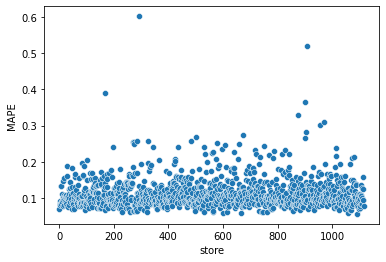

In [108]:
sns.scatterplot(x='store',y='MAPE',data=df92)

## 9.2. Total Perfomance

In [109]:
df93=df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})
df93['Values']=df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$285,982,336.00"
1,worst_scenario,"R$285,122,909.38"
2,best_scenario,"R$286,841,799.87"


## 9.3. Machine Learning Performance

In [110]:
df9['error']=df9['sales']-df9['predictions']
df9['error_rate']=df9['predictions']/df9['sales']

c:\Users\rafae\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\rafae\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

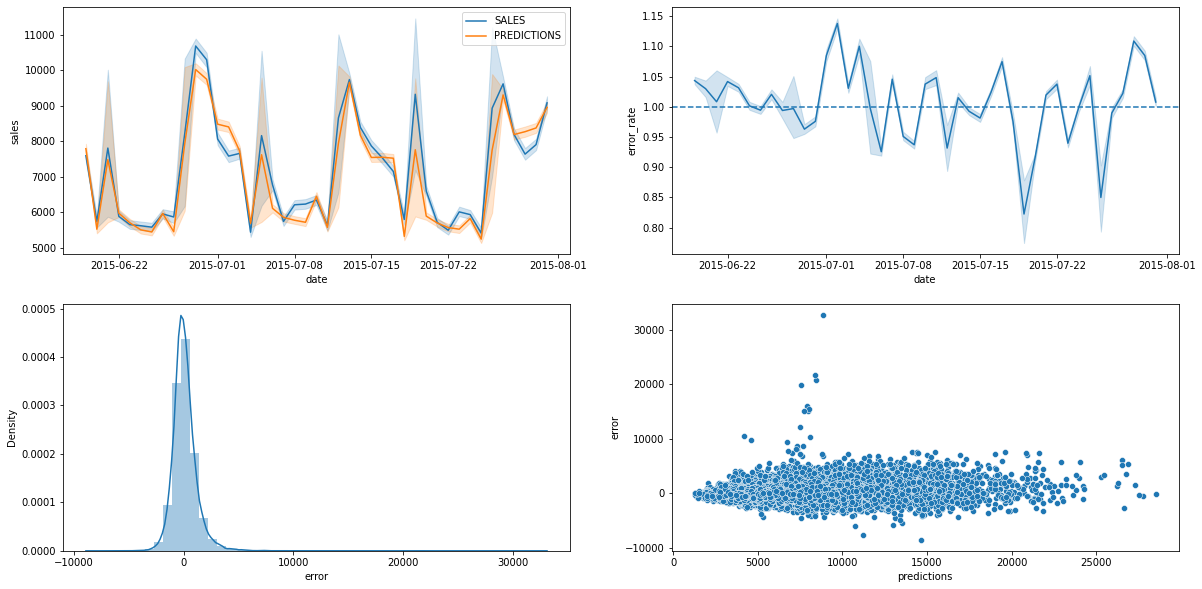

In [111]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='SALES')
sns.lineplot(x='date',y='predictions',data=df9,label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9)
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'],df9['error'])

# 10.0. PASSO 10 - DEPLOY MODEL PRODUCTION

In [115]:
# Save Trained Model
pickle.dump(model_xgb_tuned,open('./model/model_rossman.pkl','wb'))

## 10.1. Rossman Class

In [113]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path='C:/Users/rafae/Documents/repos/data_science_em_producao/'
        self.competition_distance_scaler    =pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl','rb'))
        self.competition_time_month_scaler  =pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler         =pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl','rb'))
        self.year_scaler                    =pickle.load(open(self.home_path + 'parameter/year_scaler.pkl','rb'))
        self.store_type_scaler              =pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl','rb'))

    def data_cleaning(self,df1):
        ## 1.1. Rename Columns
        cols_old=['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']
        snakecase=lambda x: inflection.underscore(x)
        cols_new=list(map(snakecase, cols_old))
        df1.columns=cols_new
        ## 1.3. Data Types
        df1['date']=pd.to_datetime(df1['date'])
        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance']=df1['competition_distance'].apply(lambda x:200000.0 if math.isnan(x) else x)
        #competition_open_since_month
        df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)
        #competition_open_since_year
        df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
        #promo2_since_week
        df1['promo2_since_week']=df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)
        #promo2_since_year
        df1['promo2_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)
        #promo_interval
        month_map={1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec',}
        df1['promo_interval'].fillna(0,inplace=True)
        df1['month_map']=df1['date'].dt.month.map(month_map)
        df1['is_promo']=df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)
        ## 1.6. Change Types
        df1['competition_open_since_month']=df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year']=df1['competition_open_since_year'].astype('int64')
        df1['promo2_since_week']=df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year']=df1['promo2_since_year'].astype('int64')
        return(df1)

    def feature_engeneering(self,df2):
        ## 2.4. feature engeneering
        # year
        df2['year']=df2['date'].dt.year
        # month
        df2['month']=df2['date'].dt.month
        # day
        df2['day']=df2['date'].dt.day
        # week of year
        df2['week_of_year']=df2['date'].dt.weekofyear
        # year week
        df2['year_week']=df2['date'].dt.strftime('%Y-%W')
        # competition since
        df2['competition_since']=df2.apply(lambda x:datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
        df2['competition_time_month']=((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')
        # promo since
        df2['promo_since']=df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
        df2['promo_since']=df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w')-datetime.timedelta(days=7))
        df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
        # assortment
        df2['assortment']=df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')
        # state holiday
        df2['state_holiday']=df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christimas' if x=='c' else 'regular_day')
        ## 3.1. Filtragem das Linhas
        df2=df2[df2['open']!=0]
        ## 3.2. Filtragem das Colunas
        cols_drop=['open','promo_interval','month_map']
        df2=df2.drop(cols_drop, axis=1)
        return(df2)

    def data_preparation(self,df5):
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance']=self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        # competition time month
        df5['competition_time_month']=self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        # promo time week
        df5['promo_time_week']=self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        # year
        df5['year']=self.year_scaler.fit_transform(df5[['year']].values)
        ## 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5=pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])
        # store type - Label Encoding
        df5['store_type']=self.store_type_scaler.fit_transform(df5['store_type'])
        # assortment - Ordinal Encoding
        assortment_dict={'basic':1,'extra':2,'extended':3}
        df5['assortment']=df5['assortment'].map(assortment_dict)
        ## 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin']=df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
        df5['day_of_week_cos']=df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))
        # month
        df5['month_sin']=df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
        df5['month_cos']=df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))
        # day
        df5['day_sin']=df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
        df5['day_cos']=df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))
        # week_of_year
        df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
        df5['week_of_year_cos']=df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))
        # boruta cols select
        cols_selected = ['store','promo','store_type','assortment','competition_distance',
                        'competition_open_since_month','competition_open_since_year','promo2',
                        'promo2_since_week','promo2_since_year','competition_time_month',
                        'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin',
                        'month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        return(df5[cols_selected])
    
    def get_prediction(self,model,original_data,test_data):
        # prediction
        pred=model.predict(test_data)

        # join pred into the origianl data
        original_data['prediction']=np.expm1(pred)

        return original_data.to_json(orient='records',date_format='iso')


## 10.2. API Handler

In [116]:
import pickle
import pandas as pd
from flask                  import Flask,request,Response
from api.rossmann.rossmann  import Rossmann

# loading model
model=pickle.load(open('./model/model_rossman.pkl','rb'))

# initialize API
app=Flask(__name__)
@app.route('/rossmann/predict',methods=['POST'])

def rossmann_predict():
    test_json=request.get_jason()
    if test_json:   # there is data
        if isinstance(test_json,dict):  # unique exemple
            test_raw=pd.DataFrame(test_json,index=[0])
        else:   # multiple example
            test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
            
        pipeline=Rossmann()
        # data cleaning
        df1=pipeline.data_cleaning(test_raw)
        # feature engeneering
        df2=pipeline.feature_engeneering(df1)
        # data preparation
        df3=pipeline.data_preparation(df2)
        # prediction
        df_response=pipeline.get_prediction(model,test_raw,df3)
        return df_response
    else:
        return Response('{}',status=200,mimetype='application/json')
if __name__ == '__main__':
    app.run('0.0.0.0')

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.204:5000 (Press CTRL+C to quit)


## 10.3. API Tester

In [ ]:
import pandas as pd
import json
import requests

# load test dataset
df_store_raw=pd.read_csv('./data/store.csv', low_memory=False)
df10=pd.read_csv('./data/test.csv')

In [ ]:
# merge test dataset + store
df_test=pd.merge(df10,df_store_raw,how='left',on='Store')

# choose store for prediction
df_test=df_test[df_test['Store'].isin([20,12,22])]

# remove closed days
df_test=df_test[df_test['Open']!=0]
df_test=df_test[~df_test['Open'].isnull()]
df_test=df_test.drop('Id',axis=1)

In [ ]:
# data convert Dataframe to json
data=json.dumps(df_test.to_dict(orient='records'))

In [ ]:
# api call
#url='http://0.0.0.0:5000/rossmann/predict'                             # utilizar o 0.0.0.0 ou o seu IP quando tiver o handler.py rodando localmente
#url='https://rafael-rossmann-model.herokuapp.com/rossmann/predict'     # utilizar para testar no modelo online    
header={'content-type':'application/json'}
data=data

r=requests.post(url,data=data,headers=header)
print('Status code {}'.format(r.status_code))

Status code 200


In [ ]:
d1=pd.DataFrame(r.json(),columns=r.json()[0].keys())

In [ ]:
d2=d1[['store','prediction']].groupby('store').sum().reset_index()
for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'],d2.loc[i,'prediction']))

Store Number 12 will sell R$240,253.11 in the next 6 weeks
Store Number 20 will sell R$307,343.69 in the next 6 weeks
Store Number 22 will sell R$177,256.35 in the next 6 weeks
